In [1]:
import leaderbot as lb
import json
import pandas as pd
import tqdm
import numpy as np

input_file = 'clean_battle_20240814_public.json'

# Download Input File if it Does Not Exists

Note that the inpout file ``clean_battle_20240814_public.json`` has 2GB in size. The following function downloads it if it does not exists. Also, at the end of this notebook script, delete this file to not take much space for the repository.

In [ ]:
# Download input file if it does not exists

import os
import requests
from tqdm import tqdm

def ensure_file_exists(filename, url):
    """
    Check if the file exists locally; if not, download it.
    """

    if not os.path.exists(filename):
        print(f"{filename} not found locally. Downloading from {url}...")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                total_size = int(r.headers.get('content-length', 0))
                with tqdm(total=total_size, unit='B', unit_scale=True, desc=f"Downloading {filename}") as progress:
                    for chunk in r.iter_content(chunk_size=8192): 
                        f.write(chunk)
                        progress.update(len(chunk))
        print(f"{filename} has been downloaded.")
    else:
        print(f"{filename} already exists locally.")

def delete_file(filename):
    """Deletes a file if it exists."""
    if os.path.exists(filename):
        os.remove(filename)
        print(f"{filename} has been deleted.")
    else:
        print(f"{filename} does not exist.")

input_file = 'clean_battle_20240814_public.json'
download_url = 'https://storage.googleapis.com/arena_external_data/public/clean_battle_20240814_public.json'

ensure_file_exists(input_file, download_url)

# Generate Data File

Do not run these if the file ``language_specific_data.json`` is already created. 

In [2]:
def convert_by_language(input_file: str, output_file: str):
    """
    Convert raw data from Chatbot Arena into a processed JSON format 
    categorized by language, compatible with leaderbot.data.load.

    Parameters
    ----------
    input_file : str
        A `.json` filename of the raw data.

    output_file : str
        The output `.json` file to write the converted data.
    """
    # Load the JSON data
    with open(input_file, 'r') as file:
        battles = pd.read_json(file).sort_values(ascending=True, by=["tstamp"])

    # Filter anonymous battles only
    battles = battles[battles["anony"]]

    # Deduplicate data
    print("Before dedup: ", len(battles))
    battles = battles[
        battles["dedup_tag"].apply(lambda x: x.get("sampled", False))
    ]
    print("After dedup: ", len(battles))

    # Get all unique languages
    all_languages = battles["language"].dropna().unique().tolist()

    # Add "All" as a pseudo-language to process all battles
    all_languages.append("All")

    # Initialize container for language-specific datasets
    language_datasets = {}

    for language in all_languages:
        # Filter battles by language
        if language == "All":
            filtered_battles = battles
        else:
            filtered_battles = battles[battles["language"] == language]

        # Skip if no battles for this language
        if filtered_battles.empty:
            continue

        # Get unique model names for this language
        combined_series = pd.concat(
            [filtered_battles["model_a"], filtered_battles["model_b"]]
        ).drop_duplicates()
        model_list = sorted(combined_series.tolist())

        # Initialize data_dict and model reverse mapping
        data_dict = {}
        reverse_dict = {m: i for i, m in enumerate(model_list)}

        # Process matches for this language
        for _, row in filtered_battles.iterrows():
            model_a, model_b = row["model_a"], row["model_b"]
            model_a_id = reverse_dict[model_a]
            model_b_id = reverse_dict[model_b]

            if row["winner"] == "model_a":
                index = 0
            elif row["winner"] == "model_b":
                index = 1
            elif row["winner"] == "tie":
                index = 2
            else:  # both bad
                index = 3

            if model_a_id < model_b_id:
                pair = (model_a_id, model_b_id)
            else:
                pair = (model_b_id, model_a_id)
                index = [1, 0, 2, 3][index]  # Flip winner

            if pair not in data_dict:
                data_dict[pair] = [0, 0, 0, 0]

            data_dict[pair][index] += 1

        # Sort the data
        data = list(data_dict.items())
        data.sort(key=lambda x: x[0])

        # Create dataset for this language
        dataset = {
            "models": model_list,
            "X": [x[0] for x in data],
            "Y": [x[1][:4] for x in data],
        }

        # Store dataset and match count
        language_datasets[language] = {
            "data": dataset,
            "n": len(filtered_battles),
        }

    # Write to output file
    with open(output_file, "w") as f:
        json.dump(language_datasets, f)


In [3]:
convert_by_language(
    input_file="clean_battle_20240814_public.json",
    output_file="language_specific_data.json"
)

Before dedup:  1799991
After dedup:  1670250


# Train Moldes Per Language

Start from here if ``language_specific_data.json`` is created.

In [2]:
filename = 'language_specific_data.json'
with open(filename, 'rb') as f:
    data_all_lang = json.load(f)

In [3]:
top_languages = sorted(
    [(lang, meta["n"]) for lang, meta in data_all_lang.items() if lang != "unknown"],
    key=lambda x: x[1], reverse=True
)

In [4]:
models = []
for lang, n in top_languages[:31]:
    print(f'{lang:>20} {n:>8}')
    
    data = data_all_lang[lang]['data']
    X = np.array(data['X'])
    Y = np.array(data['Y'])
    Y = Y[:, :3]
    
    data['X'] = X
    data['Y'] = Y

    model = lb.models.DavidsonScaled(data)
    model.train()

    models.append(model)

                 All  1670250
             English  1002297
             Chinese   176980
             Russian   145145
              German    49625
              Korean    37006
            Japanese    34377
              French    28254
             Spanish    27627
          Portuguese    16699
          Vietnamese    13589
             Italian    13348
             Persian     9343
               Czech     7464
              Polish     6614
              Arabic     5216
           Ukrainian     5111
             Turkish     4999
               Dutch     2748
              Danish     2310
             Swedish     2299
          Indonesian     2238
           Hungarian     2065
             Finnish     2001
             Serbian     1836
           Bulgarian     1648
              Hebrew     1527
               Latin     1219
           Norwegian     1128
                Thai     1006
            Romanian     1002


In [5]:
n_models = 5
n_lang = 31

for i, info in enumerate(top_languages[:n_lang]):
    lang, n = info
    print(f'| {i:>2} | {n:>8} | {lang:>11} | ', end='')

    rnk = models[i].rank()
    names = np.array(models[i].agents)[rnk]
    names.tolist()[:n_models]

    for name in names[:n_models]:
        if len(name) > 20:
            name = name[:20]
        print(f'{name:>22}  ', end='')
    print('|')

|  0 |  1670250 |         All |      chatgpt-4o-latest    gemini-1.5-pro-exp-0       gpt-4o-2024-05-13    gpt-4o-mini-2024-07-    claude-3-5-sonnet-20  |
|  1 |  1002297 |     English |      chatgpt-4o-latest    gemini-1.5-pro-exp-0       gpt-4o-2024-05-13    llama-3.1-405b-instr    gpt-4o-mini-2024-07-  |
|  2 |   176980 |     Chinese |      chatgpt-4o-latest    gemini-1.5-pro-exp-0    gemini-advanced-0514    gemini-1.5-pro-api-0       gpt-4o-2024-05-13  |
|  3 |   145145 |     Russian |      chatgpt-4o-latest    gemini-1.5-pro-exp-0    gemini-advanced-0514    claude-3-5-sonnet-20    gemini-1.5-pro-api-0  |
|  4 |    49625 |      German |   gemini-1.5-pro-exp-0       chatgpt-4o-latest    gemini-advanced-0514    gpt-4o-mini-2024-07-       gpt-4o-2024-05-13  |
|  5 |    37006 |      Korean |   codellama-70b-instru    bard-jan-24-gemini-p              gemini-pro       chatgpt-4o-latest    openhermes-2.5-mistr  |
|  6 |    34377 |    Japanese |       falcon-180b-chat    gemini-1.5-pro-exp

# Plot Ranks Per Language

In [6]:
from matplotlib.colors import ListedColormap

def generate_custom_colormap(num_shades=5, num_colors=8):
    """
    Generate a custom colormap with multiple shades for each base color.

    Parameters
    ----------
    num_shades : int
        Number of shades to generate per base color.
    num_colors : int
        Number of base colors to create shades from.

    Returns
    -------
    cmap : ListedColormap
        A Matplotlib colormap containing num_shades * num_colors colors.
    """
    # Define base colors (vibrant to dull)
    base_colors = [
        (1.0, 0.4, 0.0),  # Vibrant orange/red
        (0.1, 0.4, 0.8),  # Vibrant blue
        (0.2, 0.6, 0.2),  # Green
        # (0.6, 0.2, 0.6),  # Purple
        (0.8, 0.2, 0.8),  # Bright magenta (distinct from purple)
        (0.2, 0.8, 0.8),  # Cyan (distinct blue-green)
        (0.8, 0.6, 0.2),  # Yellow ochre
        (0.3, 0.1, 0.6),  # Dark blue-violet
        (0.5, 0.5, 0.5),  # Gray
        # (0.4, 0.4, 0.4),  # Dark gray
    ]

    # Generate shades for each base color
    colormap = []
    for base_color in base_colors[:num_colors]:
        for i in range(num_shades):
            shade = lighten_color(base_color, factor=1 - (i / (num_shades + 1)))
            colormap.append(shade)

    return ListedColormap(colormap)  # Return as a Matplotlib ListedColormap


def lighten_color(color, factor=0.4):
    """
    Lighten a given RGB color.

    Parameters
    ----------
    color : tuple
        A tuple (R, G, B) with values between 0 and 1.
    factor : float
        A factor between 0 and 1 to control lightness (higher = lighter).

    Returns
    -------
    new_color : tuple
        A lighter version of the input color, ensuring valid RGB ranges.
    """
    h, l, s = colorsys.rgb_to_hls(*color)
    l = min(1.0, max(0.0, l * factor + (1 - factor)))  # Ensure lightness is within bounds
    return tuple(min(1.0, max(0.0, c)) for c in colorsys.hls_to_rgb(h, l, s))  # Clamp values

Plot saved to "/home/sia/Dropbox/test/arena/rank_by_lang.svg".
Plot saved to "/home/sia/Dropbox/test/arena/rank_by_lang.pdf".


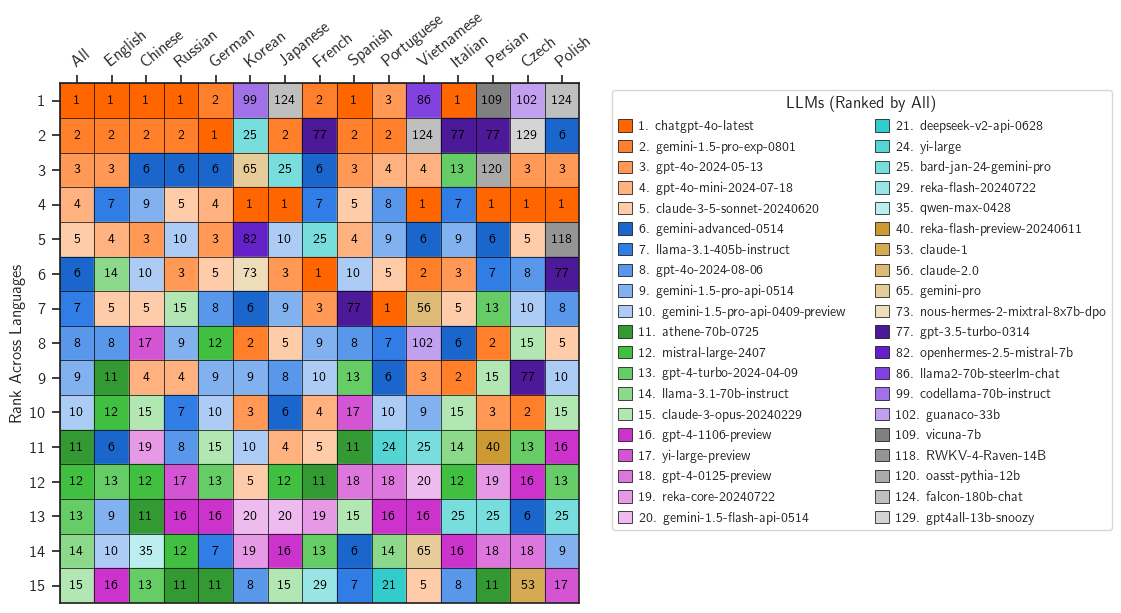

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import numpy as np
from matplotlib.transforms import Affine2D
import texplot
import seaborn as sns
import colorsys

n_lang = 15  # Number of languages on x-axis
n_rank = 15  # Number of ranks on y-axis

# Step 1: Top n_lang languages
languages = [info[0] for info in top_languages[:n_lang]]

# Step 2: Collect LLMs to determine unique colors
llms_in_plot = []
language_rankings = []
for lang_idx, lang in enumerate(languages):
    ranking = models[lang_idx].rank()
    agents = models[lang_idx].agents
    top_llms = [agents[i] for i in ranking[:n_rank] if i < len(agents)]
    llms_in_plot.extend(top_llms)
    language_rankings.append(top_llms)

# Step 1: Get global LLM rankings from "All"
all_ranked_llms = models[0].rank()  # Assuming models[0] corresponds to "All"
all_llm_names = np.array(models[0].agents)[all_ranked_llms]

# unique_llms = sorted(set(llms_in_plot))  # Unique LLMs appearing in the plot
unique_llms = [llm for llm in all_llm_names if llm in set(llms_in_plot)]
# palette = sns.color_palette("Set3", n_colors=len(unique_llms))
# llm_to_color = {llm: palette[i % len(palette)] for i, llm in enumerate(unique_llms)}
# cmap = cm.get_cmap('tab20', len(unique_llms))  # Use tab20 for up to 20 distinct base colors
# llm_to_color = {llm: mcolors.to_hex(cmap(i)) for i, llm in enumerate(unique_llms)}

# cmap = cm.get_cmap('tab20b', len(unique_llms))  
# llm_to_color = {llm: mcolors.to_hex(cmap(i)) for i, llm in enumerate(unique_llms)}

# Step 1: Get the tab20 colormap
# cmap = cm.get_cmap('tab20c')  # tab20 has 20 base colors
cmap = generate_custom_colormap(num_shades=5, num_colors=8)
n_colors = cmap.N  # Total number of colors in tab20 (20)

# Step 2: LLMs sorted by "All" ranking
unique_llms = [llm for llm in all_llm_names if llm in set(llms_in_plot)]  # Preserve "All" rank order

# Step 3: Assign colors, cycling through tab20 if needed
llm_to_color = {llm: mcolors.to_hex(cmap(i % n_colors)) for i, llm in enumerate(unique_llms)}


# n_colors = len(unique_llms)  # Number of unique LLMs
# cmap = cm.get_cmap('jet', n_colors)  # 'hsv' or 'turbo' are good for wide variety
# llm_to_color = {llm: mcolors.to_hex(cmap(i / n_colors)) for i, llm in enumerate(unique_llms)}



# def generate_n_colors(n):
#     """Generate n distinct colors using HSV color space."""
#     return [mcolors.to_hex(colorsys.hsv_to_rgb(i / n, 0.65, 0.9)) for i in range(n)]

# # Step 1: Generate 30 distinct colors
# unique_colors = generate_n_colors(len(unique_llms))
# llm_to_color = {llm: color for llm, color in zip(unique_llms, unique_colors)}




# Step 1: Get global LLM rankings from "All"
all_ranked_llms = models[0].rank()  # Assuming models[0] corresponds to "All"
all_llm_names = np.array(models[0].agents)[all_ranked_llms]
llm_to_global_rank = {llm: rank + 1 for rank, llm in enumerate(all_llm_names)}  # Map LLM to its rank in "All"

with texplot.theme(use_latex=True, rc={'font.family': 'sans-serif'}, font_scale=1):
    
    # Step 3: Plot grid
    fig_width = 1.4 + n_lang * 0.6  # Adjust 0.6 to control width scaling
    fig_height = n_rank * 0.6  # Adjust 0.6 to control height scaling
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # fig, ax = plt.subplots(figsize=(10, 6))

    for x, top_llms in enumerate(language_rankings):
        for y, llm in enumerate(top_llms):
            color = llm_to_color[llm]
            ax.add_patch(patches.Rectangle((x, y), 1, 1, color=color, edgecolor="black"))

            # Use the global rank of the LLM from the "All" column
            global_rank = llm_to_global_rank.get(llm, "?")
            ax.text(x + 0.5, y + 0.5, f"{global_rank}", ha='center', va='center', 
                    fontsize=10, color='black', weight='bold')

    # Draw grid lines explicitly
    for x in range(n_lang + 1):  # Vertical grid lines
        ax.vlines(x, 0, n_rank, colors="black", linewidth=0.5, zorder=1)
    
    for y in range(n_rank + 1):  # Horizontal grid lines
        ax.hlines(y, 0, n_lang, colors="black", linewidth=0.5, zorder=1)
    
    # Step 4: Adjust axis properties
    ax.set_aspect('equal')
    ax.set_xlim(0, n_lang)
    ax.set_ylim(0, n_rank)
    ax.set_xticks(np.arange(n_lang) + 0.5)
    ax.set_xticklabels(languages, rotation=45, ha="right", fontsize=10)
    ax.set_yticks(np.arange(n_rank) + 0.5)
    ax.set_yticklabels(range(1, n_rank + 1), fontsize=10)
    
    ax.set_xlabel("")
    ax.set_ylabel("Rank Across Languages", fontsize=12)
    
    # Move x-tick labels to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Correct alignment of x-tick labels
    ax.set_xticks(np.arange(n_lang) + 0.5)  # Center the labels
    ax.set_xticklabels(languages)
    
    # Rotate x-axis labels for better visibility
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
        label.set_transform(label.get_transform() + Affine2D().translate(-8, 0))
    ax.tick_params(axis='x', rotation=39, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.invert_yaxis()

    # Step 2: Sort legend handles based on the "All" ranking, and add global ranks
    sorted_handles = []
    for rank, llm in enumerate(all_llm_names):  # Iterate over sorted LLMs
        if llm in llm_to_color:  # Only include LLMs present in the plot
            color = llm_to_color[llm]
            handle = patches.Patch(facecolor=color, edgecolor="black", label=f"{rank+1}. {llm}", linewidth=0.5)
            sorted_handles.append(handle)
    
    # Step 3: Add legend to the plot
    ax.legend(handles=sorted_handles, title="LLMs (Ranked by All)", bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, handleheight=1, handlelength=1, handletextpad=0.5, ncols=2)

    plt.tight_layout()
    
    texplot.show_or_save_plot(plt, default_filename='rank_by_lang',
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

In [8]:
len(unique_llms)

40

# Kendall Tau Bar Plot w.r.t All

Plot saved to "/home/sia/Dropbox/test/arena/rank_by_lang_kendall_bar.svg".
Plot saved to "/home/sia/Dropbox/test/arena/rank_by_lang_kendall_bar.pdf".


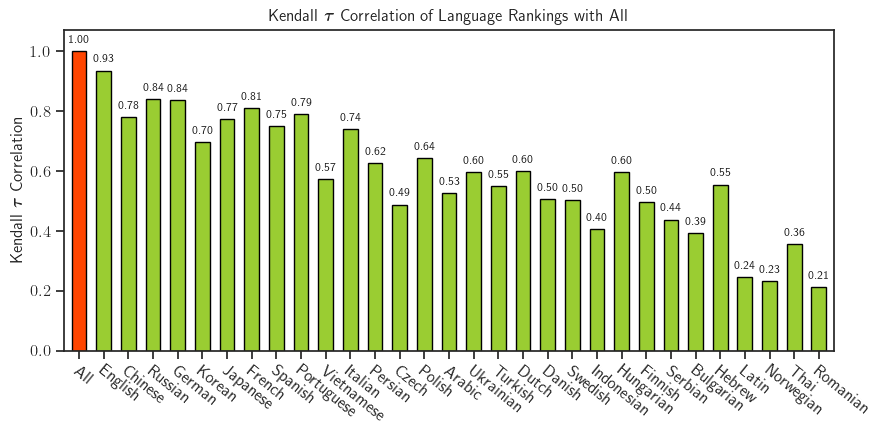

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np

n_lang = 31  # Adjust this to control the number of languages (e.g., 15, 30, etc.)

# Step 1: Prepare data
all_ranked_llms = models[0].rank()  # "All" ranking
all_llm_names = np.array(models[0].agents)[all_ranked_llms]  # LLMs sorted by All
all_ranking_dict = {llm: i for i, llm in enumerate(all_llm_names)}  # Map LLM to rank in "All"

kendall_correlations = []  # Store Kendall tau correlations
language_labels = []  # Language labels for the plot

# Top n_lang languages
languages = [info[0] for info in top_languages[:n_lang]]

# Step 2: Compute Kendall tau correlation for each language
for lang_idx, lang in enumerate(languages):
    ranking = models[lang_idx].rank()
    agents = models[lang_idx].agents
    language_llm_names = [agents[i] for i in ranking]

    # Find shared LLMs between All and the current language
    shared_llms = [llm for llm in language_llm_names if llm in all_ranking_dict]
    if len(shared_llms) < 2:
        # Skip if not enough shared LLMs to compute Kendall tau
        kendall_correlations.append(0)  # No correlation possible
        language_labels.append(lang)
        continue

    # Step 3: Extract ranks for shared LLMs
    all_ranks = [all_ranking_dict[llm] for llm in shared_llms]
    lang_ranks = [language_llm_names.index(llm) for llm in shared_llms]

    # Compute Kendall tau correlation
    tau, _ = kendalltau(all_ranks, lang_ranks)
    kendall_correlations.append(tau)
    language_labels.append(lang)

with texplot.theme(use_latex=True, rc={'font.family': 'sans-serif'}, font_scale=1):

    bar_colors = ['orangered' if label == "All" else "yellowgreen" for label in language_labels]
    
    # Step 4: Plot Kendall tau correlations as a bar chart
    fig, ax = plt.subplots(figsize=(9, 4.5))
    width = 0.6
    bars = ax.bar(language_labels, kendall_correlations, color=bar_colors, edgecolor="black", width=width)
    ax.set_xticks(range(len(language_labels)))  # Set tick positions
    ax.set_xticklabels(language_labels)
    ax.set_ylabel(r"Kendall $\boldsymbol{\tau}$ Correlation")
    ax.set_title(r"Kendall $\boldsymbol{\tau}$ Correlation of Language Rankings with All")
    
    # Annotate the bars with correlation values
    for bar, tau in zip(bars, kendall_correlations):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{tau:.2f}", 
                ha="center", va="bottom", fontsize=8)
        
    # Rotate x-axis labels for better visibility
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
        label.set_transform(label.get_transform() + Affine2D().translate(-8, 0))
    ax.tick_params(axis='x', rotation=-39, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlim(-width, len(kendall_correlations) - (1- width))
    ax.set_ylim([0, 1.07])
    
    plt.tight_layout()
    texplot.show_or_save_plot(plt, default_filename='rank_by_lang_kendall_bar',
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

# Kendall Tau Matrix w.r.t Mutual Lang

In [104]:
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np
import texplot

n_lang = 31  # Number of languages to compare

# Step 1: Prepare data
languages = [info[0] for info in top_languages[:n_lang]]  # Top languages
ranking_dicts = []  # Store LLM-to-rank mappings for each language

# Build ranking dictionaries for each language
for lang_idx in range(n_lang):
    ranking = models[lang_idx].rank()
    agents = models[lang_idx].agents
    ranking_dict = {agents[i]: rank for rank, i in enumerate(ranking)}  # LLM to rank
    ranking_dicts.append(ranking_dict)

# Initialize Kendall tau correlation matrix
kendall_matrix = np.zeros((n_lang, n_lang))

# Step 2: Compute Kendall tau correlations
for i in range(n_lang):
    for j in range(i, n_lang):  # Compute only the upper triangle
        if i == j:
            kendall_matrix[i, j] = 1.0  # Diagonal: perfect correlation
            continue

        # Find shared LLMs between language i and j
        shared_llms = list(set(ranking_dicts[i].keys()) & set(ranking_dicts[j].keys()))
        if len(shared_llms) < 2:  # Not enough shared LLMs
            kendall_matrix[i, j] = kendall_matrix[j, i] = 0
            continue

        # Extract ranks for shared LLMs
        ranks_i = [ranking_dicts[i][llm] for llm in shared_llms]
        ranks_j = [ranking_dicts[j][llm] for llm in shared_llms]

        # Compute Kendall tau correlation
        tau, _ = kendalltau(ranks_i, ranks_j)
        kendall_matrix[i, j] = kendall_matrix[j, i] = tau

# Clustering Kendall Tau Matrix

In [105]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import optimal_leaf_ordering
from scipy.spatial.distance import squareform

def reorder(matrix, method='average', convert_to_dist=False):
    """
    Is matrix is a correlation matrix, it should be converted to a distance matrix
    where its diagonals are zero. To do this, set convert_to_dist=True.
    """

    if convert_to_dist:
        diag = np.diag(matrix)
        dist_matrix = 1.0 - matrix / np.sqrt(np.outer(diag, diag))
    else:
        dist_matrix = matrix

    # Perform hierarchical clustering
    # linkage = sch.linkage(matrix, method='average')
    dist_matrix_condensed = squareform(dist_matrix, checks=True)

    # NOTE: ths input to linkage function MUST be a condensed array. If a 2D array (like distance matrix)
    # is given, the linkage assumes a 2D array is the array of observations, not the distance array, and hence,
    # it tries to compute distance matrix from tga presumed observation matrix. This is clearly not what
    # we intend. Instead, to pass a pre-computed distance matrix, the matrix should be converted to a 1D
    # condensed distance array (see squareform in the above).
    linkage = sch.linkage(dist_matrix_condensed, method=method, metric='euclidean', optimal_ordering=True)
    #linkage = sch.linkage(matrix, method='average', optimal_ordering=True)
    
    # Compute optimal leaf ordering
    ordered_linkage = optimal_leaf_ordering(linkage, dist_matrix_condensed)
 
    # Reorder based on optimal leaf ordering
    dendro = sch.dendrogram(ordered_linkage, no_plot=True)
    indices = dendro['leaves']
    
    # Reorder the matrix
    reordered_matrix = matrix[np.ix_(indices, indices)]

    return reordered_matrix, indices

In [106]:
def cor_plot(fig, ax, matrix, names, horizontal=True, cmap=None, use_weight=False):
    """
    """

    ax.set_frame_on(False)
    ax.set_aspect(2.0)

    n = matrix.shape[0]

    if horizontal:
        matrix = np.triu(matrix)
    # else:
    #     matrix = np.tril(matrix)
    matrix = np.ma.masked_array(matrix, matrix == 0)
    
    # Set the diagonal to zero.
    for i in range(n):
        matrix[i, i] = 1

    #if not horizontal:
    matrix = np.flipud(matrix)
    #matrix = np.fliplr

    # Transformation matrix for rotating the heatmap.
    #A = np.array([(y, x) for x in range(n, -1, -1) for y in range(n + 1)])
    x_ = np.linspace(-0.5, 0.5, n+1)
    y_ = np.linspace(-0.5, 0.5, n+1)

    if horizontal is False:
        x_ = x_[::-1]
        
    A = np.array([(y, x) for x in x_ for y in y_])
    t = np.array([[0.5, 1.0],
                  [0.5, -1.0]])
    A = np.dot(A, t)

    min_val = np.min(matrix)
    min_val = 0.0 # TEST
    min_val = np.floor(min_val * 100.0) / 100.0
    n_snaps = int(100 - min_val * 100.0)
    
    if cmap is None:
        cmap = plt.cm.cividis
    norm = matplotlib.colors.BoundaryNorm(np.linspace(min_val, 1, 20+1), cmap.N)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(n + 1, n + 1)
    Y = A[:, 0].reshape(n + 1, n + 1)
    caxes = ax.pcolormesh(X, Y, matrix, axes=ax, cmap=cmap, norm=norm,
                          edgecolors=(0.5, 0.5, 0.5, 0.2), linewidth=0.1)

    # Plotting the border
    ax.plot([X[-1, 0], X[-1, -1], X[0, -1], X[-1, 0]], 
            [Y[-1, 0], Y[-1, -1], Y[0, -1], Y[-1, 0]],
            color='black', lw=0.65, zorder=10)

    for i in range(n):
        ax.text(X[n-i, i] + 1/n, Y[n-i, i] - 0.25/n, names[i], ha='center', va='top', rotation=-90, zorder=20, fontsize=12)
        # ax.text(X[n-i, i] + 1/n, Y[n-i, i] - 2.0/n, names[i][1], ha='center', va='center', rotation=0, zorder=20)
        # ax.text(X[n-i, i] + 1/n + 0.005, Y[n-i, i] - 3.3/n, names[i][2], ha='center', va='center', rotation=0, zorder=20)

    # Remove the ticks and reset the x limit.
    if horizontal:
        ax.set_ylim(bottom=0)
    else:
        ax.set_xlim(right=0)

    # Add a colorbar below the heatmap triangle.
    cb = fig.colorbar(caxes, ax=ax, orientation='horizontal', shrink=0.5825,
                      fraction=0.05, pad=-0.035, ticks=np.linspace(min_val, 1, 4+1),
                      use_gridspec=True)

    if use_weight:
        clabel = r"Weighted Kendall $\boldsymbol{\tau}$ Correlation"
    else:
        clabel = r"Kendall $\boldsymbol{\tau}$ Correlation"
    cb.set_label(clabel, fontsize=12)
    
    # Set colorbar tick labels as percentages
    ticks = cb.get_ticks()
    cb.set_ticks(ticks)
    #cb.set_ticklabels([f'{100 * tick:.0f}%' for tick in ticks])
    cb.set_ticklabels([rf'${100 * tick:.0f}\%$' for tick in ticks])

    cb.ax.set_position([0.13, 0.155, 0.27, 0.4])

    return X, Y, cb

Plot saved to "/home/sia/Dropbox/test/arena/rank_by_lang_kendall_matrix.svg".
Plot saved to "/home/sia/Dropbox/test/arena/rank_by_lang_kendall_matrix.pdf".


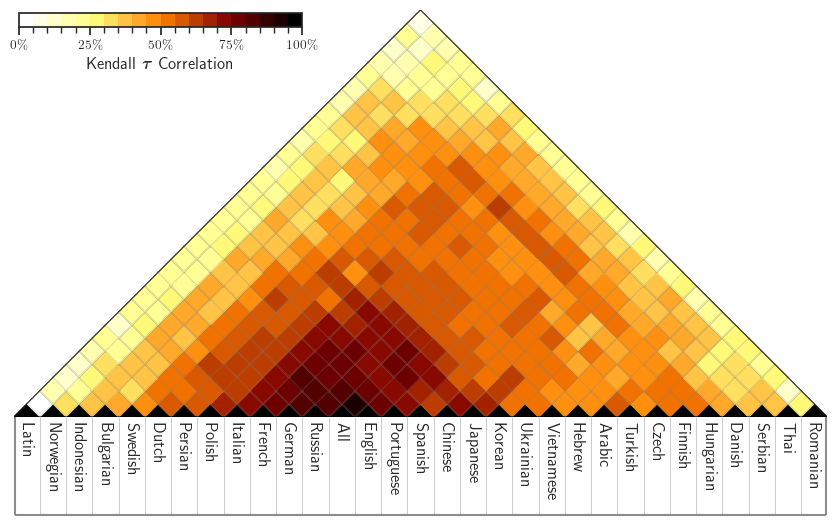

In [107]:
from matplotlib.gridspec import GridSpec
import matplotlib

# fig, ax = plt.subplots(figsize=(14, 14))
fig = plt.figure(figsize=(10.5, 12))
gs = GridSpec(2, 1, height_ratios=[5, 1], hspace=-0.09)

ax_top = fig.add_subplot(gs[0])
ax_top.set_aspect(2.0)
ax_top.set_frame_on(False)  # Turn off the frame

stat = kendall_matrix
model_names = np.array(languages)

method = 'average'
ordered_stat, indices = reorder(stat, method=method, convert_to_dist=True)

# indices = np.array([
#     4, 1, 7, 8, 9, 10, 19, 20, 21, 22,
#     6, 3, 15, 16, 17, 18, 27, 28, 29, 30,
#     5, 2, 11, 12, 13, 14, 23, 24, 25, 26,
# ]) - 1

# indices = np.r_[indices[:10], indices[20:], indices[10:20]]
#indices = np.r_[indices[:10], indices[10:20][::-1], indices[20:30]]
#indices = np.r_[indices[:10], indices[20:][::-1], indices[10:20][::-1]]


ordered_stat = stat[np.ix_(indices, indices)]
ordered_names = model_names[indices]

# with texplot.theme(rc=rc, use_latex=True):

rc = {
    'font.family': 'sans-serif',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{amsfonts} \usepackage{pifont}',
}


with texplot.theme(use_latex=True, font_scale=0.85):
    plt.rcParams.update(rc)

    cmap = plt.cm.afmhot_r

    use_weight = False
    X, Y, cb = cor_plot(fig, ax_top, ordered_stat, ordered_names, horizontal=True, cmap=cmap, use_weight=use_weight)
    
    ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
    ax_bottom.set_aspect(0.24)
    
    # Hide all tick marks and labels
    ax_bottom.set_xticks([])
    ax_bottom.set_yticks([])
    
    # Hide axis frame
    ax_bottom.axis('off')
    
    # Invert the y-axis so that zero is at the boundary between the two axes
    ax_bottom.invert_yaxis()
    
    n = X.shape[0]
    epsilon = 0.003
    for i in range(n):
        x = 2.0*(X[i, i]+Y[i, i])
        if i == 0: x += epsilon
        if i == n-1: x -= epsilon
        # if i % 10 == 0:
        if i  == 0 or i == n-1:
            linewidth = 1.5
            color = (0.5, 0.5, 0.5, 0.9)
        else:
            linewidth = 0.75
            color = (0.5, 0.5, 0.5, 0.4)
        
        ax_bottom.vlines(x, 0.295, 1.3, color=color, linewidth=linewidth)
    
    # ax_bottom.text(-1.14, 0.52, r'\textbf{Model}')
    # ax_bottom.text(-1.14, 0.87, r'\textbf{Cov} ($k$)')
    # ax_bottom.text(-1.14, 1.23, r'\textbf{Tie} ($k$)')
    
    #ax_bottom.hlines(0.22, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    # ax_bottom.hlines(0.65, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    # ax_bottom.hlines(0.99, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(1.3, -1+epsilon, 1-epsilon, color=(0.5, 0.5, 0.5, 0.9), linewidth=1.5)
    #ax_bottom.vlines(-1.15, 0.22, 1.25, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    
    # ax_bottom.add_patch(plt.Rectangle((-1+epsilon, 0.65), 2-2*epsilon, 0.99-0.65, facecolor=(0.5, 0.5, 0.5, 0.15),
    #                                   edgecolor='none', zorder=-1000))
    
    # ax_bottom.set_xlim(left=-1.14)
    ax_bottom.set_xlim(left=-1)

    ax_bottom.set_zorder(0)
    ax_top.set_zorder(1)

    texplot.show_or_save_plot(plt, default_filename='rank_by_lang_kendall_matrix',
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

# Delete Input file (2GB in size)

In [ ]:
# Delete input file as it takes 2GB in size
delete_file(input_file)